# Predicting fuel efficiency

Basic regression

In [1]:
#importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

np.set_printoptions(precision=3, suppress=True) ## this makes NumPy printouts easier to read.

# Loading data from path

In [2]:
#fetch file and location path
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

rdata = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
data = rdata.copy()
data.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


# Data cleaning

In [3]:
#access na values
data.isna().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [4]:
#drop existing na
data=data.dropna()

- Using pd.get_dummies to transform the origin attribute from numeric to categorical by one-hot encode 

In [5]:
data['Origin'] = data['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [6]:
data = pd.get_dummies(data, columns=['Origin'], prefix='', prefix_sep='')
data.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


# Split the data into train and test sets

In [7]:
#spliting datasets into a training & test set
train_data = data.sample(frac=0.8, random_state=0)
test_data = data.drop(train_data.index)

# Inspect the data

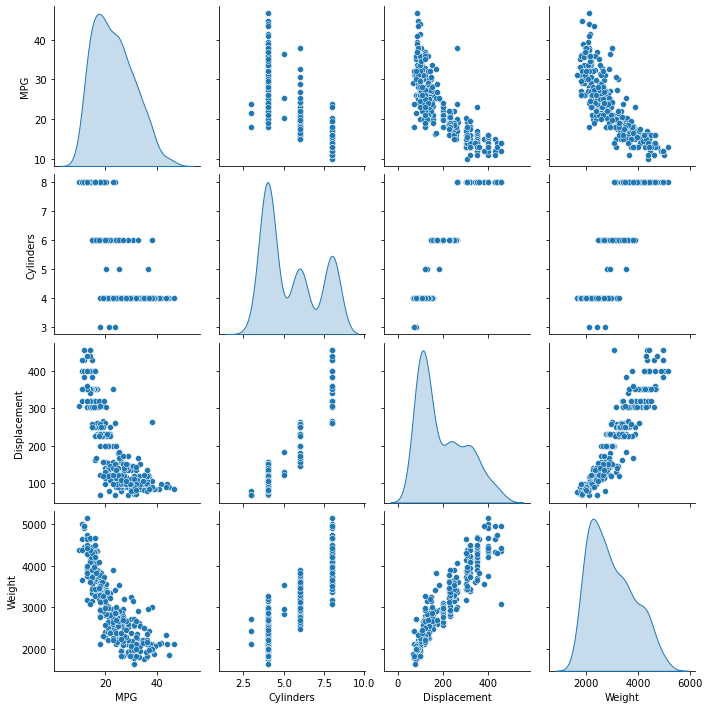

In [8]:
# Reviewing the joint distribution of a few pairs of columns from the training set.
##plot the distribution

sns.pairplot(train_data[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

In [9]:
#statistics of the attributes
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


# Split features from labels

In [10]:
#Separating the target value—the "label"—from the features. This label is the value that is used to train the model to predict.
train_features = train_data.copy()
test_features = test_data.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# Normalization

In [11]:
train_data.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [12]:
#normalization makes training much more stable.
## tf.keras.layers.Normalization is a clean and simple way to add feature normalization into the model.
### create the layer
normalizer = tf.keras.layers.Normalization(axis=-1)

In [13]:
#fit the state of the preprocessing layer to the data by using Normalization.adapt
normalizer.adapt(np.array(train_features))

In [14]:
#Calculating the mean and variance, and storing them in the layer:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


When the layer is called, it returns the input data, with each feature independently normalized

In [15]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Linear regression

Before building a deep neural network model, I start with linear regression using one and several variables.
- I Begin with a single-variable linear regression to predict 'MPG' from 'Horsepower'.

Training a model with tf.keras typically starts by defining the model architecture. tf.keras.Sequential model, which represents a sequence of steps.

The two steps in single-variable linear regression model are:

- Normalize the 'Horsepower' input features using the tf.keras.layers.Normalization preprocessing layer.
- Apply a linear transformation (y=mx+b) to produce 1 output using a linear layer (tf.keras.layers.Dense).

In [16]:
# creating a NumPy array made of the 'Horsepower' features. Then, instantiating the tf.keras.layers.Normalization and fit its state to the horsepower data:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

- Building the Keras Sequential model:

In [17]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict 'MPG' from 'Horsepower'

In [18]:
#Running the untrained model on the first 10 'Horsepower' values. 
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 160ms/step


array([[-0.655],
       [-0.37 ],
       [ 1.208],
       [-0.918],
       [-0.83 ],
       [-0.326],
       [-0.983],
       [-0.83 ],
       [-0.216],
       [-0.37 ]], dtype=float32)

- After buiding the model,the training procedure is configured using the Keras Model.compile method. The most important arguments to compile are the loss and the optimizer, these define what will be optimized (mean_absolute_error) and how (using the tf.keras.optimizers.Adam).

In [ ]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# Using (Keras Model.fit) to execute the training for 100 epochs:

In [21]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 6.86 s
Wall time: 5.85 s


In [26]:
histry = pd.DataFrame(history.history)
histry['epoch'] = history.epoch
histry.tail()

,loss,val_loss,epoch
95,3.805130,4.200875,95
96,3.805321,4.169241,96
97,3.806146,4.162533,97
98,3.818744,4.131464,98
99,3.818074,4.197828,99


Visualization of the model's training progress using the stats stored in the history object.

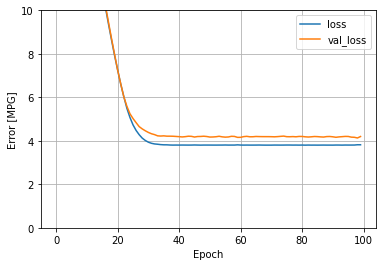

In [28]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [29]:
#Collecting the results on the test set for later.
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

# For a single variable regression,the model's *predictions* as a function of the input 

In [30]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


In [31]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

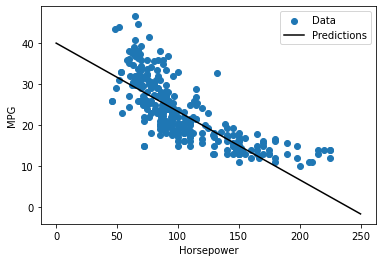

In [32]:
plot_horsepower(x, y)

# Linear regression with multiple inputs

Creating a two-step Keras Sequential model again with the first layer being normalizer

In [33]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

calling Model.predict on a batch of inputs, it will produce units=1 outputs for each example

In [34]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 201ms/step


array([[-0.036],
       [ 1.076],
       [-1.481],
       [ 1.481],
       [ 0.807],
       [ 0.472],
       [ 0.834],
       [ 2.611],
       [-0.307],
       [-0.565]], dtype=float32)

When calling the model, its weight matrices will be built—check that the kernel weights (the *m* in *y=mx+b*) have a shape of (9, 1):

In [35]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.364],
       [-0.16 ],
       [-0.46 ],
       [ 0.439],
       [ 0.078],
       [ 0.637],
       [ 0.344],
       [-0.119],
       [ 0.046]], dtype=float32)>

- Configuring the model with *Keras Model.compile* and training with Model.fit for 100 epochs:

In [36]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [37]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 7.05 s
Wall time: 6.39 s


The Use of *all the inputs* in this regression model achieves a much lower training and validation error than the horsepower_model, which had one input

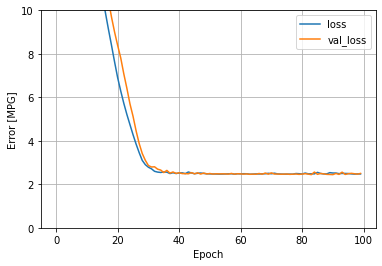

In [38]:
plot_loss(history)

In [39]:
#Collecting the results on the test set for later reveiw
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# Regression with a deep neural network (DNN)

- Implementing single-input and multiple-input DNN models.

These models will contain a few more layers than the linear model:

- The normalization layer, as before (with *horsepower_normalizer* for a single-input model and *normalizer* for a multiple-input model).
- Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.
- A linear Dense single-output layer.
Both models will use the same training procedure, so the *compile* method is included in the *build_and_compile_model* function below.

In [40]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

- For a single input *DNN*..;

In [41]:
#This model has quite a few more trainable parameters than the linear models
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [42]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model with Keras *Model.fit*

In [43]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 8.5 s
Wall time: 7.8 s


This very model performs slightly better than the linear *single-input horsepower_model*

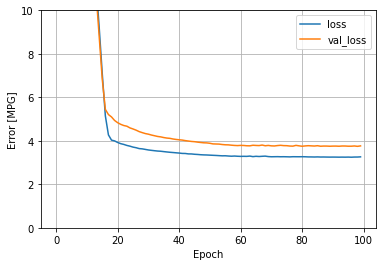

In [44]:
plot_loss(history)

8/8 [==============================] - 0s 2ms/step


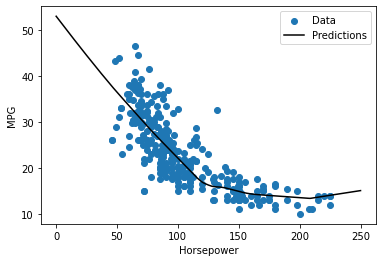

In [45]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)
plot_horsepower(x, y)

Ploting the predictions as a function of *'Horsepower'*,  from the observation it shows this model takes advantage of the nonlinearity provided by the hidden layers.

In [46]:
#Collecting the results on the test set for later reveiw..
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

- Regression using a *DNN* and *multiple inputs*;

In [47]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [48]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 9.27 s
Wall time: 8.75 s


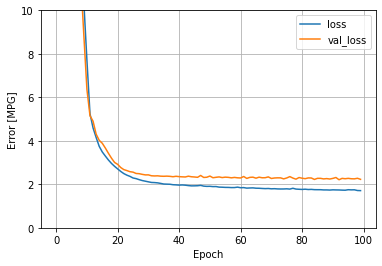

In [49]:
plot_loss(history)

In [50]:
#collecting result
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# Performance

- Reviewing the test set performance,after all models have been trained

In [51]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.661990
linear_model,2.527303
dnn_horsepower_model,2.880475
dnn_model,1.772258


# Making the predictions

- Making predictions with the *dnn_model* on the test set using Keras Model.predict and review the loss:

3/3 [==============================] - 0s 4ms/step


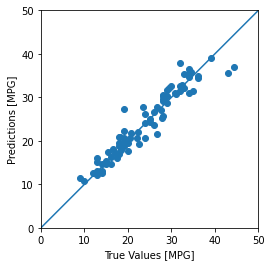

In [52]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

 The model predicts reasonably well from the observation

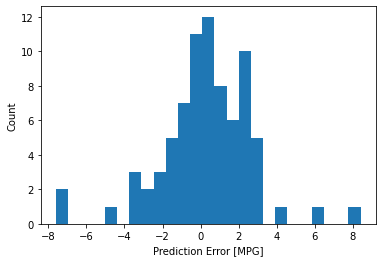

In [53]:
#checking the *error distribution*

error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [54]:
#save model
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


INFO:tensorflow:Assets written to: dnn_model\assets


In [57]:
#reloading the model

reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.661990
linear_model,2.527303
dnn_horsepower_model,2.880475
dnn_model,1.772258
reloaded,1.772258
